In [1]:
import numpy as np
import math
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

### Build Equity Option Base Class

In [2]:
class EquityOption(object):
    def __init__(self, K, N, v, S0=1, is_Euro=True):

        '''
        define all the common attributes for an option
        S0: initial asset price is 1
        K: the strike price of the option
        N: number of time periods 
        v: the up factor of the stock tree is (1+v), the down factor of the stock tree is (1-v)
        rf: the borrowing/lending interest rate for a single time period is 0.
        p: the up and down probability of the binomial tree is 0.5
        is_Euro: if the option is European style. If is_Euro = False then the option is American style 
    
        '''
        
        self.S0 = 1
        self.K = K
        self.N = N
        self.u = 1+v
        self.d = 1-v
        self.rf = 0
        self.p = 0.5
        self.is_Euro = True
    
        
class BinomialOption(EquityOption):
    def __init__(self, K, N, v, S0=1, is_Euro=True):
        '''
        Initialize the option and an empty price tree 
        '''
        EquityOption.__init__(self, K, N, v, S0=1, is_Euro=True)
        self.price_tree = [np.array([self.S0])]
    
    def get_price_tree(self):
        return self.price_tree
    
    def set_price_tree(self):
        '''
        build the stock price tree based on n period binomial model 
        starting from the root going forward
        '''
        for i in range(1,self.N+1):
            price_leafs = np.array([])
            for j in range(i+1):
                next_price = self.S0*( (self.u**j) * self.d**(i-j) )
                price_leafs=np.append(price_leafs, next_price)
            self.price_tree.append(price_leafs)
        return self.price_tree


### Question 1: Pricing European call option

In [3]:
class EuropeanOption(BinomialOption):
    '''
    Price European option
    '''
    
    def calc_payoff(self, price_tree):
        '''
        calculate the payoff at terminal node for a call option
        '''
        return np.maximum(self.price_tree[self.N] - self.K, 0)
    
    def discount_payoff(self, payoffs):
        '''
        Based on n period binomial model, the expected payoff at period N =/
        dicsount factor(=1)*sum(payoff)*nCk*( p**k )*( (1-p)**(n-k) )
        '''
        expected_payoff = 0
        for k in range(0,self.N+1): #k is the number of up movements in the terminal node
            payoff = payoffs[k]
            comb = math.factorial(self.N)/( math.factorial(k)*math.factorial(self.N-k) ) # combinations of k up movements out of n periods
            expected_payoff += payoff*comb*(self.p**k)*(self.p**(self.N-k))
            option = expected_payoff #since Rf=0
            
        return option
            
    def price_option(self):
        price_tree = self.set_price_tree()
        payoffs = self.calc_payoff(price_tree)
        return self.discount_payoff(payoffs)

In [8]:
eu_option = EuropeanOption(1.1, 3, 0.5)     
# tr=eu_option.set_price_tree()
# print(tr)
#eu_option.calc_payoff(tr)
print('European call option price=',eu_option.price_option())

European call option price= 0.29374999999999996


### Question 2: Calibrate v to given option value V

In [11]:
def __calibrate_option__(v, K, N, V):
    '''
    V: given market European call option price
    v is the variable, K, N and V are arguments
    '''
    option = EuropeanOption(K, N, v)    
    option_price = option.price_option()
    return option_price - V
    
def __calc_v__(K, N, V): 
    
    guess = 0.1
    arg = (K, N, V)
    result = fsolve(__calibrate_option__, guess, args=arg)
    
    try:
        v = result
    except ValueError:
        raise ValueError(result.message)
    
    return v[0]

In [13]:

print('Given K=1, N=3, V=0.34375, v=',__calc_v__(1,3,0.34375))   

Given K=1, N=3, V=0.34375, v= 0.5000000000000003


### Question 3: Pricing American call option

In [14]:
class AmericanOption(BinomialOption):
    '''
    Price American option
    '''
    
    def calc_payoff(self, price_tree):
        '''
        calculate the payoff at terminal node for a call option
        '''
        return np.maximum(self.price_tree[self.N] - self.K, 0)
    
    def exercise_early(self, payoffs, period):
        '''
        If American option is exercised before maturity, compare the payoff max(St-K, 0) 
        with discounted value at each node
        '''
        return np.maximum(payoffs, self.price_tree[period]-self.K)
    
    def discount_payoff(self, payoffs):
        for i in np.arange(self.N-1, -1, -1):
            payoffs = (payoffs[:-1]+payoffs[1:])*self.p
        
        if not self.is_Euro:
            payoffs = self.exercise_early(payoffs, i)
        
        option = payoffs[0]
        return option
            
    def price_option(self):
        price_tree = self.set_price_tree()
        payoffs = self.calc_payoff(price_tree)
        return self.discount_payoff(payoffs)

In [15]:
am_option = AmericanOption(1.1, 3, 0.5, is_Euro=False)     
print('American call option price=',am_option.price_option())

American call option price= 0.29374999999999996


### Question 4: Calculate the expected value of max(Sj)

E[max(Sj)] 
<br>= E(max(S1, S2,..., SN))
<br>= E(S1) * P(S1>=S1,...SN)+...+E(SN) * P(SN>=S1,...SN)
<br>= P(S1>=S1,...SN)+P(S2>=S1,...SN)+...+P(SN>=S2,...SN) E(Sj) = 1 based on the below calculation
<br>= 1
    
Thus we only need to show E(Sj)=1 for all 1<=j<=N

In [16]:
def calc_exp_S(v, period, S0=1, p=0.5, Rf=0):
    '''
    Calculate the sum of expected value of Sn for each period n
    Based on binomial model, E[Sn] = sum(S0*( u**k )*( d**(n-k))*nCk*( p**k )*( q**(n-k) ),
    N, n:time period
    k:number of upward movements
    u,d = 1+v, 1-v: up and down factor
    p = 0.5
    '''
    exp_S = 0
    for k in range(period+1): #k = 0, ..., N
        comb = math.factorial(period)/( math.factorial(k)*math.factorial(period-k) )
        exp_S += S0*( (1+v)**k )*( (1-v)**(period-k) )*(p**period)*comb
    return exp_S
    
def plot_exp_max_Sj(K, N, v):
    '''
    The function calulcates and plots the expected value of max(Sj) for different values of v

    '''
    all_exp_S = []
    v_range = np.arange(0.0, 1.0, 0.1) 
    for v in v_range: 
        exp_S = calc_exp_S(v, N, S0=1, p=0.5, Rf=0)
        all_exp_S.append(exp_S)

    plt.figure()
    plt.plot(v_range, all_exp_S)
    plt.title('factor v VS E[S]')
    plt.xlabel('v')
    plt.ylabel('E[S]')
    plt.show()     

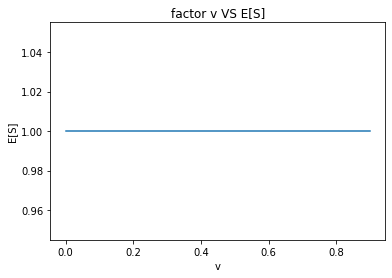

In [18]:
plot_exp_max_Sj(1, 4, 0.9)